This is part is loading of the dataset from Kaggle to the google colab

In [2]:
!pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download g2net-gravitational-wave-detection

100% 69.0G/69.0G [13:38<00:00, 127MB/s]
100% 69.0G/69.0G [13:38<00:00, 90.5MB/s]


In [7]:
! mkdir g2net-gw

In [ ]:
! unzip g2net-gravitational-wave-detection.zip -d g2net-gw

Now we can install all the required packages

In [9]:
!pip install nnAudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00


In [10]:
#All the imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import AUC

import librosa.display
import torch

# this is used for Contant Q Transform
from nnAudio.Spectrogram import CQT1992v2
from tensorflow.keras.applications import EfficientNetB0 as efn

We look at the data and then combine them with their corresponding paths to get a compact dataset

In [ ]:
train_labels = pd.read_csv("/content/g2net-gw/training_labels.csv")
train_labels.head()

In [12]:
train_path = glob("/content/g2net-gw/train/*/*/*/*")

In [13]:
# get the list of ids from the .npy files
ids_from_npy_files = [path.split("/")[-1].split(".")[0] for path in train_path]

# get a dataframe with paths and ids of those .npy files
df_path_id = pd.DataFrame({'path': train_path, 'id':ids_from_npy_files})

# make sure that train_labels is defined and has the correct labels for your data

# merging that above df with the target
df_train = pd.merge(left=train_labels, right=df_path_id, on='id')
display(df_train.head())

# verifying the shape of the merged df has 5,60,000 rows and 3 columns
print(df_train.shape)


,id,target,path
0,00000e74ad,1,/content/g2net-gw/train/0/0/0/00000e74ad.npy
1,00001f4945,0,/content/g2net-gw/train/0/0/0/00001f4945.npy
2,0000661522,0,/content/g2net-gw/train/0/0/0/0000661522.npy
3,00007a006a,0,/content/g2net-gw/train/0/0/0/00007a006a.npy
4,0000a38978,1,/content/g2net-gw/train/0/0/0/0000a38978.npy


(560000, 3)


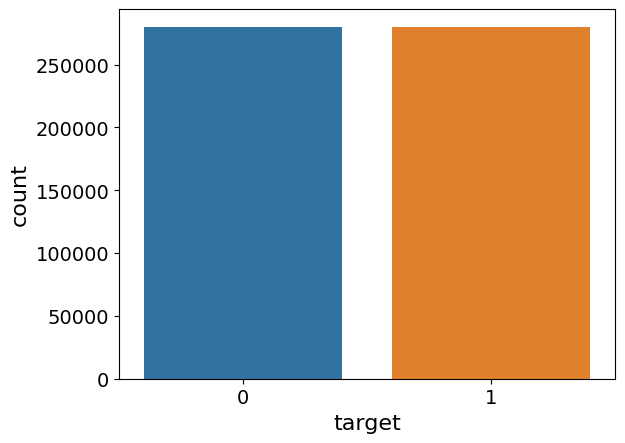

In [14]:
#checking if the data is balanced or unbalanced

sns.countplot(x = 'target', data = train_labels)
ax = plt.gca()
ax.set_xlabel('target', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("output.png", dpi=300)
plt.show()


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

def multi_plot(series, plot_type, target):
    """
    Plot multiple subplots based on the given series and plot type.

    Args:
        series (list): List of series to plot.
        plot_type (str): Type of plot to generate ('kde', or 'time').
        target (str): Target label for the plot.

    Returns:
        None
    """
    # Set the figure size according to the plot type
    if plot_type == 'kde':
        plt.figure(figsize=(12, 6))
    elif plot_type == 'time':
        plt.figure(figsize=(15,12))

    # Define colors for each type of plot
    colors = ['g', 'r', 'b']

    # Plotting
    for idx in range(3):
        if plot_type == 'kde':
            plt.subplot(1, 3, idx+1)
            sns.kdeplot(series[idx], color=colors[idx], shade=True, lw=2, alpha=0.5)
            plt.xlabel('Value', fontsize=18)
            plt.ylabel('Density', fontsize=18)

        elif plot_type == 'time':
            plt.subplot(3, 1, idx+1)
            plt.plot(series[idx].T, color=colors[idx])
            plt.xlabel('Time', fontsize=18)
            plt.ylabel('Signal', fontsize=18)
            plt.title(f"Detector-{idx+1}", fontsize=20)

        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)

    plt.tight_layout()
    plt.savefig("0_prob.png", dpi=300)  # Save the figure
    plt.show()

In [46]:
# Classify the the 2 classes of targets of 1 and 0
target_1_df_train = df_train[df_train.target == 1]
target_0_df_train = df_train[df_train.target == 0]
print("Class distribution of Target: \n ", train_labels.target.value_counts())

Class distribution of Target: 
  0    280070
1    279930
Name: target, dtype: int64


/content/g2net-gw/train/e/5/8/e58a9e377f.npy


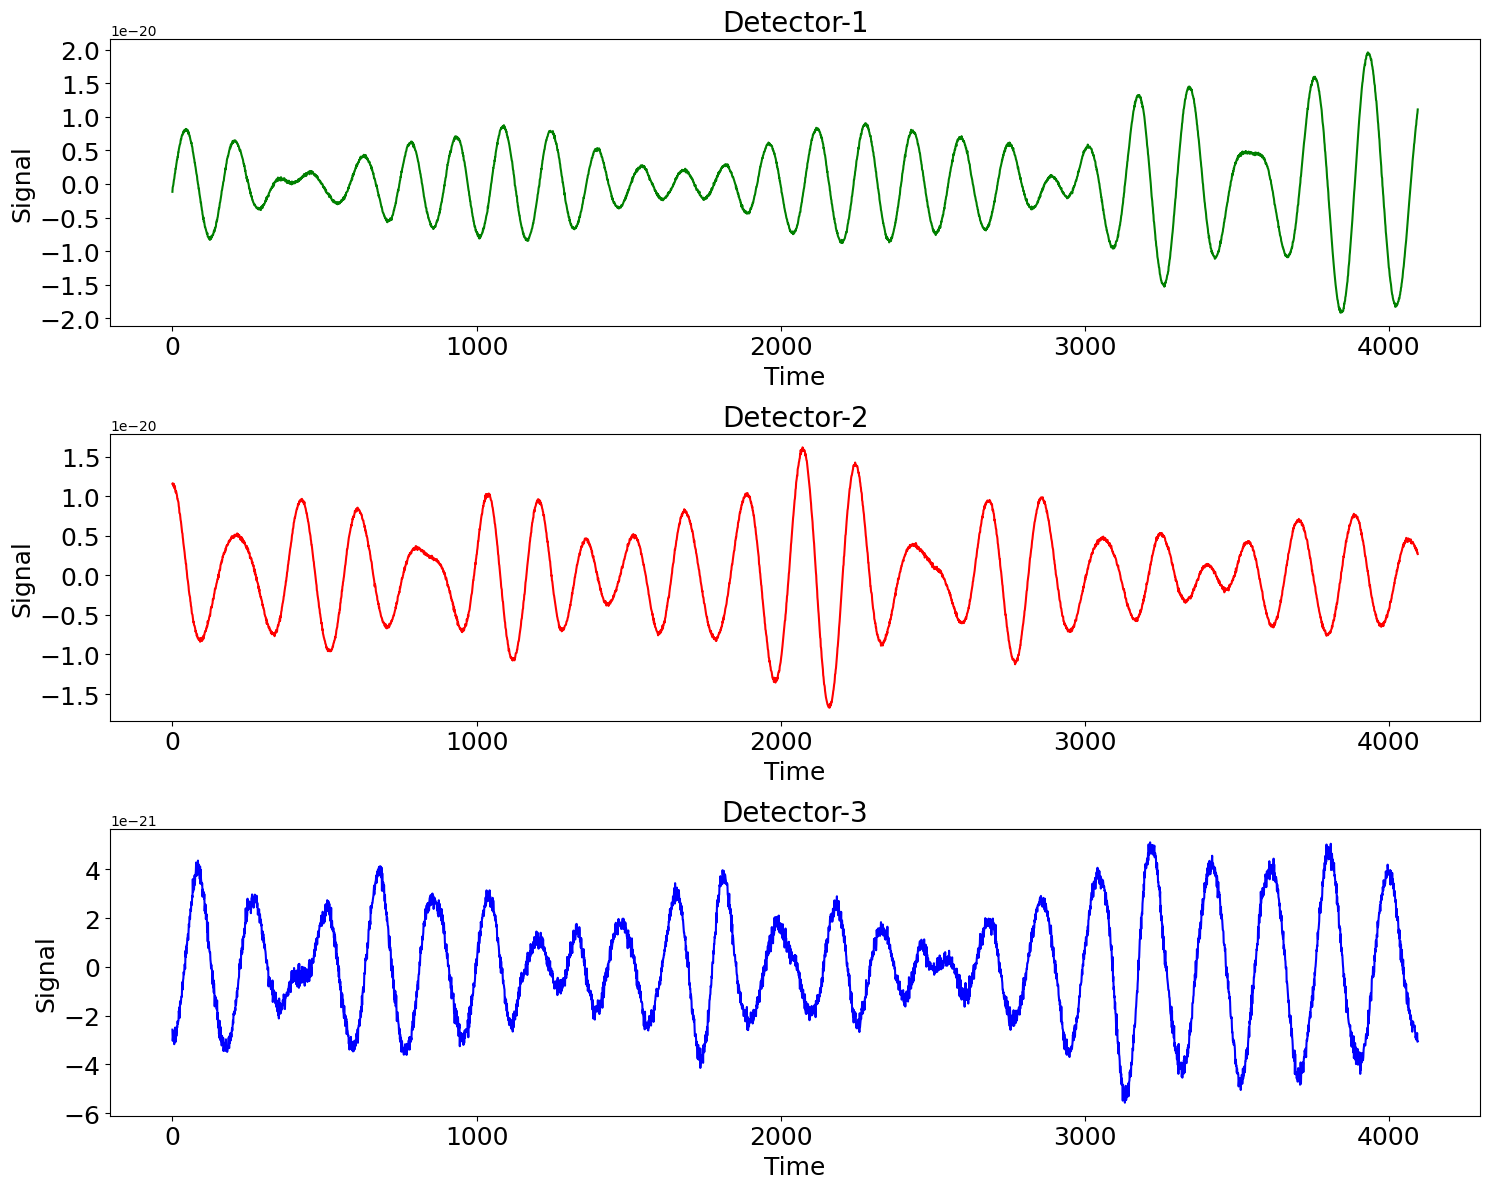

In [49]:
# Extract 1 random element from the target_1_df_train
# using random_state to ensure the reproducibility of the examples.
target_1_rand_sample_file = target_1_df_train.sample(1).path.values[0]
print(target_1_rand_sample_file)

selected_rand_series_1 = np.load(target_1_rand_sample_file)
multi_plot(selected_rand_series_1, 'time', "1")
#multi_plot(selected_rand_series_1, 'kde', "1")


/content/g2net-gw/train/3/6/8/36867a16e6.npy


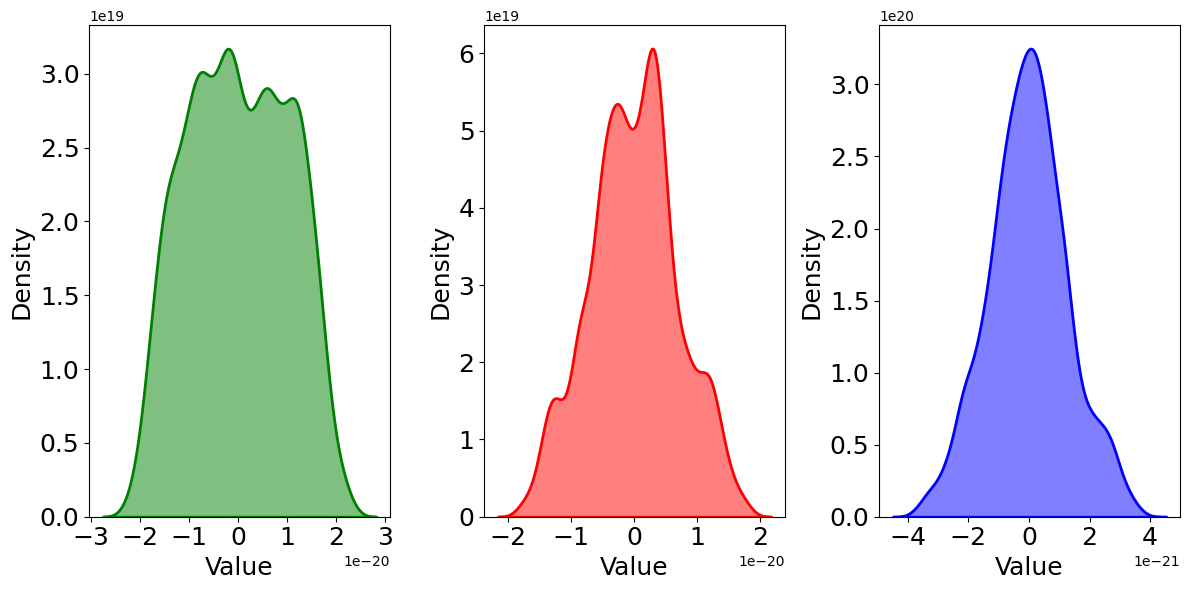

In [53]:
# Extract 1 random element from the target_0_df_train
# using random_state to ensure the reproducibility of the examples.
target_0_rand_sample_file = target_0_df_train.sample(1).path.values[0]
print(target_0_rand_sample_file)

selected_rand_series_0 = np.load(target_0_rand_sample_file)

#multi_plot(selected_rand_series_0, 'time', "0")
multi_plot(selected_rand_series_0, 'kde', "0")

Applying the CQT to convert the time series into images

CQT kernels created, time used = 0.0307 seconds


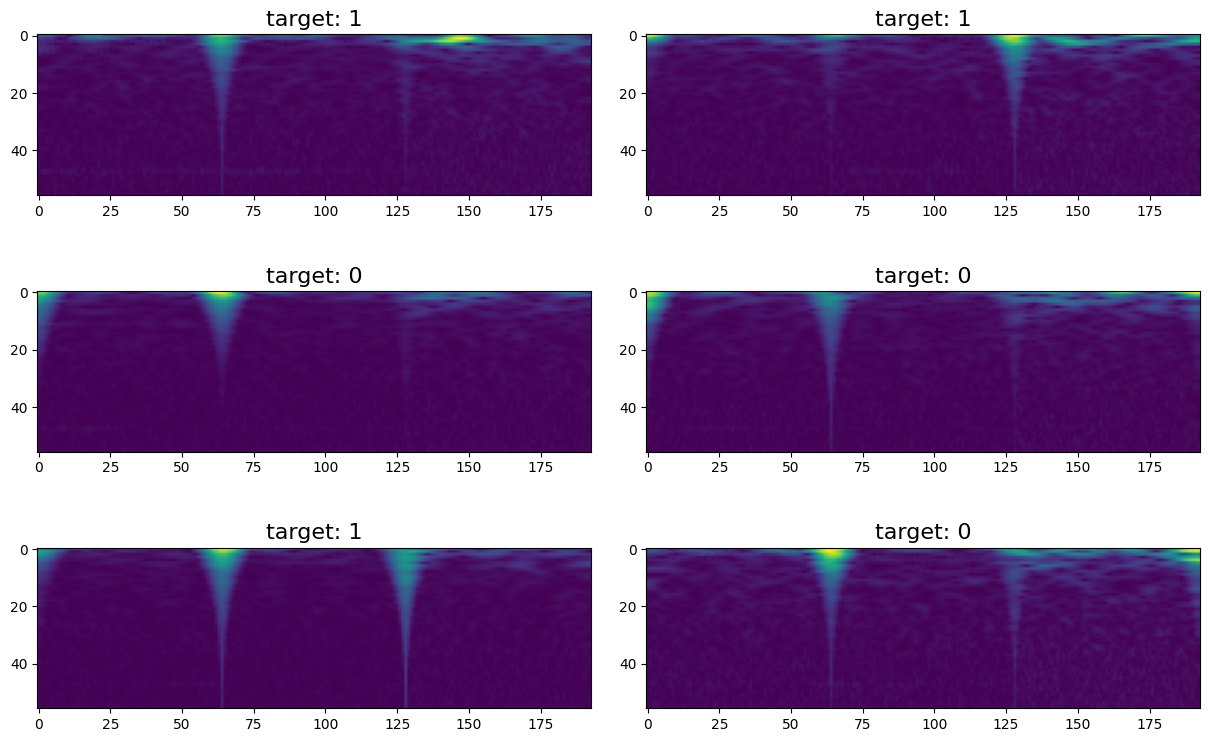

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from nnAudio.Spectrogram import CQT1992v2

# Function to show the CQT Spectogram
def get_cqt_spectrogram(
    waves_from_each_file,
    transform=CQT1992v2(sr=2048, fmin=20, fmax=500, hop_length=64),
):
    stacked_waves_from_each_file = np.hstack(waves_from_each_file)
    stacked_waves_from_each_file = stacked_waves_from_each_file / np.max(
        stacked_waves_from_each_file
    )
    stacked_waves_from_each_file = torch.from_numpy(stacked_waves_from_each_file).float()
    cqt_image = transform(stacked_waves_from_each_file)
    return cqt_image


fig, axs = plt.subplots(3, 2, figsize=(15,10))

for i in range(6):
    waves = np.load(df_train.loc[i, 'path'])
    cqt_image = get_cqt_spectrogram(waves)
    target = df_train.loc[i, 'target']
    ax = axs[i // 2, i % 2]
    ax.imshow(cqt_image[0])
    ax.set_title(f"target: {target}", fontsize=16)

# Adjust the spacing between plots
plt.subplots_adjust(wspace=0.1, hspace=-1.2)
plt.savefig('spec.png', dpi=600)

plt.show()


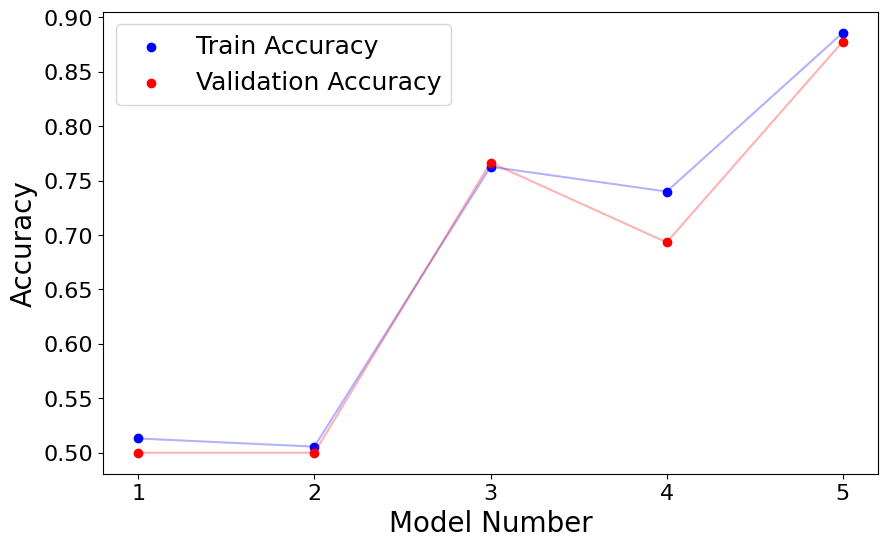

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Defining the data
model_numbers = [1, 2, 3, 4, 5]
train_accuracies = [0.5130 , 0.5055 , 0.7628, 0.74, 0.886]
validation_accuracies = [ 0.4999, 0.4999, 0.7666, 0.6933, 0.8779]

# Creating a pandas DataFrame
df = pd.DataFrame({
    'Model Number': model_numbers,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': validation_accuracies
})

# Creating the plot
plt.figure(figsize=(10,6))

plt.scatter(df['Model Number'], df['Train Accuracy'], color='blue', label='Train Accuracy')
plt.scatter(df['Model Number'], df['Validation Accuracy'], color='red', label='Validation Accuracy')

plt.plot(df['Model Number'], df['Train Accuracy'], color='blue', alpha=0.3)
plt.plot(df['Model Number'], df['Validation Accuracy'], color='red', alpha=0.3)

#plt.title('Train and Validation Accuracies for Different Models', fontsize=20)
plt.xlabel('Model Number', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

plt.xticks(model_numbers, fontsize=16)

plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.show()
